C:\Users\DELL\AppData\Local\Temp\ipykernel_4032\1924346738.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


137
📈 Évaluation du modèle Random Forest (classification délai entre pannes) :
              precision    recall  f1-score   support

        >90j       0.00      0.00      0.00         6
        ≤90j       0.57      0.89      0.70         9

    accuracy                           0.53        15
   macro avg       0.29      0.44      0.35        15
weighted avg       0.34      0.53      0.42        15

Accuracy = 0.53


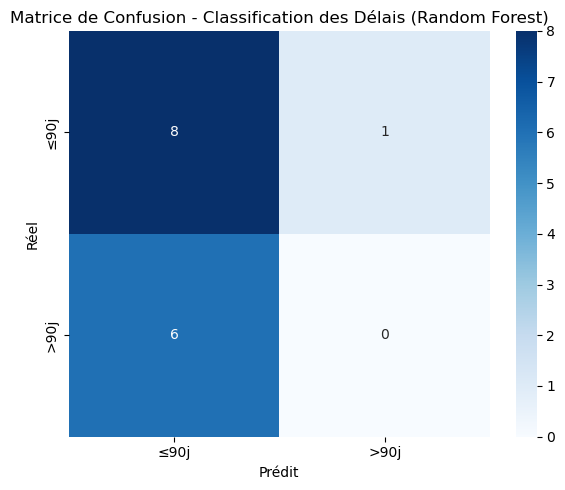

✅ Export terminé : 'resultats_prediction_pannes.csv' créé avec succès.


In [9]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 🔗 Connexion à la base SQL Server
conn = pyodbc.connect(
     'DRIVER={SQL Server};'
    'SERVER=DESKTOP-STG70TI\\SQLSERVER;'
    'DATABASE=DW_SAP_Co2;'
    'Trusted_Connection=yes;'
)

# 📥 Requête SQL pour l’historique des pannes
query = """
WITH Historique AS (
    SELECT 
        f.FK_Equipment,
        f.Fk_Material,
        f.Fk_Location,
        f.Fk_Date_Creation_Notification,
        f.FK_Notif_Type,
        f.Fk_usine,
        f.Prioryty,
        d.FullDate AS Date_Creation,
        e.Fk_Mfrequency,
        e.Fk_MCycle,
        e.Fk_Category,
        e.Fk_Energy,
        e.Manufacturer,
        e.Estimated_Lifetime_Years
    FROM Fact_MM_PM f
    JOIN Dim_Date d ON f.Fk_Date_Creation_Notification = d.Pk_Date
    JOIN Dim_Equipment e ON f.FK_Equipment = e.PK_Equipment
    WHERE f.Fk_Date_Creation_Notification IS NOT NULL
)
SELECT * FROM Historique
"""

# 📥 Charger les données
df = pd.read_sql(query, conn)
conn.close()

# ✅ Suppression des doublons
df = df.drop_duplicates(subset=['FK_Equipment', 'Fk_Date_Creation_Notification'])
print(df.shape[0])


# 🧮 Conversion des dates et tri
df['Date_Creation'] = pd.to_datetime(df['Date_Creation'])
df = df.sort_values(by=['FK_Equipment', 'Date_Creation'])

# 🆕 Ajouter la colonne Nombre_de_pannes_passées
df['Nombre_de_pannes_passées'] = df.groupby('FK_Equipment').cumcount()

# 🆕 Ajouter la colonne Mois_panne
df['Mois_panne'] = df['Date_Creation'].dt.month

# ⏱️ Calcul du délai entre pannes en JOURS
df['Delai_Entre_Pannes'] = df.groupby('FK_Equipment')['Date_Creation'].diff().dt.days
df = df.dropna(subset=['Delai_Entre_Pannes'])

# 🧠 Transformation du délai en CLASSE (2 classes : ≤90j / >90j)
def assign_delay_class(days):
    if days <= 90:
        return '≤90j'
    else:
        return '>90j'

df['Classe_Delai'] = df['Delai_Entre_Pannes'].apply(assign_delay_class)

# 🧾 Séparation des variables
X = df.drop(columns=['Date_Creation', 'Delai_Entre_Pannes', 'Classe_Delai'])
y = df['Classe_Delai']

# 🏷️ Encodage des classes pour Random Forest
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 🔄 Colonnes catégorielles
categorical_cols = [col for col in X.columns if 'Fk_' in col or col in ['Prioryty', 'Manufacturer']]

# 🏗️ Pipeline : prétraitement + modèle
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Les colonnes numériques (Nombre_de_pannes_passées, Mois_panne) passent directement
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 🔀 Séparer train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 🚀 Entraînement du modèle
pipeline.fit(X_train, y_train)

# 🔮 Prédiction
y_pred = pipeline.predict(X_test)

# 🔄 Décodage des prédictions
y_test_classes = label_encoder.inverse_transform(y_test)
y_pred_classes = label_encoder.inverse_transform(y_pred)

# 📊 Évaluation
print("📈 Évaluation du modèle Random Forest (classification délai entre pannes) :")
print(classification_report(y_test_classes, y_pred_classes))
print(f"Accuracy = {accuracy_score(y_test_classes, y_pred_classes):.2f}")

# 📉 Matrice de confusion
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_classes, y_pred_classes, labels=['≤90j', '>90j'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['≤90j', '>90j'], yticklabels=['≤90j', '>90j'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion - Classification des Délais (Random Forest)')
plt.tight_layout()
plt.show()
# 🗂️ Export des résultats en CSV

# ⚡ Attention : récupérer FK_Equipment du test set (X_test)
X_test_reset = X_test.reset_index()  # important pour avoir un index propre
fk_equipments = X_test_reset['FK_Equipment']

# 🔄 Construire un DataFrame avec équipements, classes réelles et prédictions
df_results = pd.DataFrame({
    'FK_Equipment': fk_equipments,
    'Classe_réelle': y_test_classes,
    'Classe_prédite': y_pred_classes
})

# 💾 Exporter en fichier CSV
df_results.to_csv('resultats_prediction_pannes.csv', index=False, encoding='utf-8-sig')

print("✅ Export terminé : 'resultats_prediction_pannes.csv' créé avec succès.")



C:\Users\DELL\AppData\Local\Temp\ipykernel_4032\3095239964.py:47: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


📈 Évaluation du modèle XGBoost (classification délai entre pannes) :
              precision    recall  f1-score   support

       0-30j       0.25      0.25      0.25         4
       180+j       0.00      0.00      0.00         2
      30-90j       0.25      0.20      0.22         5
     90-180j       0.20      0.25      0.22         4

    accuracy                           0.20        15
   macro avg       0.17      0.17      0.17        15
weighted avg       0.20      0.20      0.20        15

Accuracy = 0.20


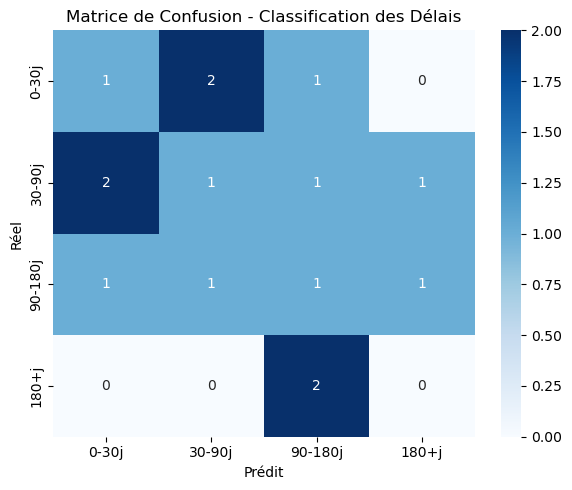

In [4]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

# 🔗 Connexion à la base SQL Server
conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=DESKTOP-STG70TI\\SQLSERVER;'
    'DATABASE=DW_SAP_Co2;'
    'Trusted_Connection=yes;'
)

# 📥 Requête SQL pour l’historique des pannes
query = """
WITH Historique AS (
    SELECT 
        f.FK_Equipment,
        f.Fk_Material,
        f.Fk_Location,
        f.Fk_Date_Creation_Notification,
        f.FK_Notif_Type,
        f.Fk_usine,
        f.Prioryty,
        d.FullDate AS Date_Creation,
        e.Fk_Mfrequency,
        e.Fk_MCycle,
        e.Fk_Category,
        e.Fk_Energy,
        e.Manufacturer,
        e.Estimated_Lifetime_Years
    FROM Fact_MM_PM f
    JOIN Dim_Date d ON f.Fk_Date_Creation_Notification = d.Pk_Date
    JOIN Dim_Equipment e ON f.FK_Equipment = e.PK_Equipment
    WHERE f.Fk_Date_Creation_Notification IS NOT NULL
)
SELECT * FROM Historique
"""

df = pd.read_sql(query, conn)
conn.close()

# ✅ Suppression des doublons par équipement + date
df = df.drop_duplicates(subset=['FK_Equipment', 'Fk_Date_Creation_Notification'])

# 🧮 Conversion et tri des dates
df['Date_Creation'] = pd.to_datetime(df['Date_Creation'])
df = df.sort_values(by=['FK_Equipment', 'Date_Creation'])

# ⏱️ Calcul du délai entre pannes EN JOURS
df['Delai_Entre_Pannes'] = df.groupby('FK_Equipment')['Date_Creation'].diff().dt.days
df = df.dropna(subset=['Delai_Entre_Pannes'])

# 🧠 Transformation du délai en CLASSE
def assign_delay_class(days):
    if days <= 30:
        return '0-30j'
    elif days <= 90:
        return '30-90j'
    elif days <= 180:
        return '90-180j'
    else:
        return '180+j'

df['Classe_Delai'] = df['Delai_Entre_Pannes'].apply(assign_delay_class)

# 🧾 Séparation des variables
X = df.drop(columns=['Date_Creation', 'Delai_Entre_Pannes', 'Classe_Delai'])
y = df['Classe_Delai']

# 🏷️ Encodage des classes pour XGBoost
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 🔄 Colonnes catégorielles
categorical_cols = [col for col in X.columns if 'Fk_' in col or col in ['Prioryty', 'Manufacturer']]

# 🏗️ Pipeline de prétraitement + modèle
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42))
])

# 🔀 Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 🚀 Entraînement
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# 🔄 Décodage pour afficher sous forme de classes texte
y_test_classes = label_encoder.inverse_transform(y_test)
y_pred_classes = label_encoder.inverse_transform(y_pred)

# 📊 Évaluation
print("📈 Évaluation du modèle XGBoost (classification délai entre pannes) :")
print(classification_report(y_test_classes, y_pred_classes))
print(f"Accuracy = {accuracy_score(y_test_classes, y_pred_classes):.2f}")

# 📉 Matrice de confusion
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_classes, y_pred_classes, labels=['0-30j', '30-90j', '90-180j', '180+j'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0-30j', '30-90j', '90-180j', '180+j'], yticklabels=['0-30j', '30-90j', '90-180j', '180+j'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion - Classification des Délais')
plt.tight_layout()
plt.show()


In [10]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Connexion SQL
conn = pyodbc.connect(
    r'DRIVER={SQL Server};'
    r'SERVER=DESKTOP-STG70TI\SQLSERVER;'
    r'DATABASE=DW_SAP_Co2;'
    r'Trusted_Connection=yes;'
)

# Charger les données
query = """
WITH Historique AS (
    SELECT 
        f.FK_Equipment,
        f.Fk_Material,
        f.Fk_Location,
        f.Fk_Date_Creation_Notification,
        f.FK_Notif_Type,
        f.Fk_usine,
        f.Prioryty,
        d.FullDate AS Date_Creation,
        e.Fk_Mfrequency,
        e.Fk_MCycle,
        e.Fk_Category,
        e.Fk_Energy,
        e.Manufacturer,
        e.Estimated_Lifetime_Years
    FROM Fact_MM_PM f
    JOIN Dim_Date d ON f.Fk_Date_Creation_Notification = d.Pk_Date
    JOIN Dim_Equipment e ON f.FK_Equipment = e.PK_Equipment
    WHERE f.Fk_Date_Creation_Notification IS NOT NULL
)
SELECT * FROM Historique
"""
df = pd.read_sql(query, conn)
conn.close()

# Préparation des données
df = df.drop_duplicates(subset=['FK_Equipment', 'Fk_Date_Creation_Notification'])
df['Date_Creation'] = pd.to_datetime(df['Date_Creation'])
df = df.sort_values(by=['FK_Equipment', 'Date_Creation'])

# Nombre de pannes passées
df['Nombre_de_pannes_passées'] = df.groupby('FK_Equipment').cumcount()
df['Mois_panne'] = df['Date_Creation'].dt.month

# Calcul du délai exact entre pannes
df['Delai_Entre_Pannes'] = df.groupby('FK_Equipment')['Date_Creation'].diff().dt.days
df = df.dropna(subset=['Delai_Entre_Pannes'])

# 🧾 Séparation des variables
X = df.drop(columns=['Date_Creation', 'Delai_Entre_Pannes'])
y = df['Delai_Entre_Pannes']

# Colonnes catégorielles
categorical_cols = [col for col in X.columns if 'Fk_' in col or col in ['Prioryty', 'Manufacturer']]

# 🏗️ Pipeline de prétraitement + modèle
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 🔀 Séparer train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🚀 Entraînement
pipeline.fit(X_train, y_train)

# 🔮 Prédiction du délai en jours
y_pred = pipeline.predict(X_test)

# 📊 Évaluation du modèle
print("📈 Évaluation du modèle Random Forest (régression sur délai) :")
print(f"MAE (Mean Absolute Error) = {mean_absolute_error(y_test, y_pred):.2f} jours")
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} jours")
print(f"R² = {r2_score(y_test, y_pred):.3f}")

# 🔥 Prédire la prochaine date de maintenance

# 1. Dernière notification par équipement
df_last = df.groupby('FK_Equipment').tail(1).copy()

# 2. Préparer X pour prédiction
X_pred = df_last.drop(columns=['Date_Creation', 'Delai_Entre_Pannes'])
delais_predits = pipeline.predict(X_pred)

# 3. Ajouter les résultats
df_last['Delai_prédit_jours'] = delais_predits
df_last['Prochaine_date_estimée'] = df_last['Date_Creation'] + pd.to_timedelta(delais_predits, unit='d')
a
# 4. Exporter
df_last_export = df_last[['FK_Equipment', 'Date_Creation', 'Delai_prédit_jours', 'Prochaine_date_estimée']]
df_last_export.to_csv('prochaine_maintenance_predite.csv', index=False, encoding='utf-8-sig')

print("✅ Export terminé : 'prochaine_maintenance_predite.csv' créé avec succès.")


C:\Users\DELL\AppData\Local\Temp\ipykernel_4032\1239431639.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


📈 Évaluation du modèle Random Forest (régression sur délai) :
MAE (Mean Absolute Error) = 53.98 jours
RMSE = 71.28 jours
R² = -0.260
✅ Export terminé : 'prochaine_maintenance_predite.csv' créé avec succès.


C:\Users\DELL\AppData\Local\Temp\ipykernel_4032\491755715.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


📈 Évaluation du modèle Random Forest (régression sur délai en jours) :
MAE = 53.98 jours
RMSE = 71.28 jours
R² = -0.260
Accuracy (erreur <= 10 jours) = 13.33%


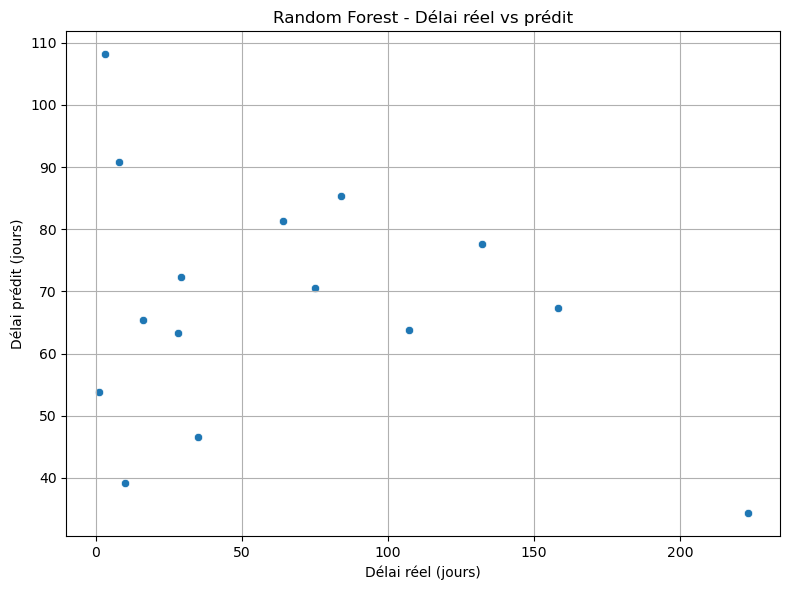

PermissionError: [Errno 13] Permission denied: 'prochaine_maintenance_predite.csv'

In [14]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ Fonction pour calculer l'accuracy avec tolérance
def accuracy_within_tolerance(y_true, y_pred, tolerance_days=10):
    correct = np.abs(y_true - y_pred) <= tolerance_days
    return np.mean(correct)

# 🔗 Connexion à la base SQL Server
conn = pyodbc.connect(
    r'DRIVER={SQL Server};'
    r'SERVER=DESKTOP-STG70TI\SQLSERVER;'
    r'DATABASE=DW_SAP_Co2;'
    r'Trusted_Connection=yes;'
)

# 📥 Requête SQL pour charger l’historique des maintenances
query = """
WITH Historique AS (
    SELECT 
        f.FK_Equipment,
        f.Fk_Material,
        f.Fk_Location,
        f.Fk_Date_Creation_Notification,
        f.FK_Notif_Type,
        f.Fk_usine,
        f.Prioryty,
        d.FullDate AS Date_Creation,
        e.Fk_Mfrequency,
        e.Fk_MCycle,
        e.Fk_Category,
        e.Fk_Energy,
        e.Manufacturer,
        e.Estimated_Lifetime_Years
    FROM Fact_MM_PM f
    JOIN Dim_Date d ON f.Fk_Date_Creation_Notification = d.Pk_Date
    JOIN Dim_Equipment e ON f.FK_Equipment = e.PK_Equipment
    WHERE f.Fk_Date_Creation_Notification IS NOT NULL
)
SELECT * FROM Historique
"""

# 📥 Charger les données
df = pd.read_sql(query, conn)
conn.close()

# 🧹 Nettoyage
df = df.drop_duplicates(subset=['FK_Equipment', 'Fk_Date_Creation_Notification'])
df['Date_Creation'] = pd.to_datetime(df['Date_Creation'])
df = df.sort_values(by=['FK_Equipment', 'Date_Creation'])

# ⏱️ Calcul du délai entre pannes (en jours)
df['Delai_Entre_Pannes'] = df.groupby('FK_Equipment')['Date_Creation'].diff().dt.days
df = df.dropna(subset=['Delai_Entre_Pannes'])

# ➕ Ajouter des features utiles
df['Nombre_de_pannes_passées'] = df.groupby('FK_Equipment').cumcount()
df['Mois_panne'] = df['Date_Creation'].dt.month

# 🧾 Séparation des variables
X = df.drop(columns=['Date_Creation', 'Delai_Entre_Pannes'])
y = df['Delai_Entre_Pannes']

# 🔄 Colonnes catégorielles
categorical_cols = [col for col in X.columns if 'Fk_' in col or col in ['Prioryty', 'Manufacturer']]

# 🏗️ Pipeline de prétraitement + modèle
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'  # Colonnes numériques passent directement
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 🔀 Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🚀 Entraînement
pipeline.fit(X_train, y_train)

# 🔮 Prédictions sur le test
y_pred = pipeline.predict(X_test)

# 📊 Évaluation classique
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
accuracy_tolerance = accuracy_within_tolerance(y_test, y_pred, tolerance_days=10)

print("📈 Évaluation du modèle Random Forest (régression sur délai en jours) :")
print(f"MAE = {mae:.2f} jours")
print(f"RMSE = {rmse:.2f} jours")
print(f"R² = {r2:.3f}")
print(f"Accuracy (erreur <= 10 jours) = {accuracy_tolerance*100:.2f}%")

# 📈 Graphique réel vs prédit
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Délai réel (jours)')
plt.ylabel('Délai prédit (jours)')
plt.title('Random Forest - Délai réel vs prédit')
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔥 Prédiction de la prochaine date de maintenance

# 1️⃣ Dernière notification de chaque équipement
df_last = df.groupby('FK_Equipment').tail(1).copy()

# 2️⃣ Préparation pour prédiction
X_pred = df_last.drop(columns=['Date_Creation', 'Delai_Entre_Pannes'])
delais_predits = pipeline.predict(X_pred)

# 3️⃣ ARRONDIR le délai en jours
delais_predits = np.ceil(delais_predits)

# 4️⃣ Ajouter résultats
df_last['Delai_prédit_jours'] = delais_predits
df_last['Prochaine_date_estimée'] = df_last['Date_Creation'] + pd.to_timedelta(df_last['Delai_prédit_jours'], unit='d')

# 5️⃣ Exporter
df_last_export = df_last[['FK_Equipment', 'Date_Creation', 'Delai_prédit_jours', 'Prochaine_date_estimée']]
df_last_export.to_csv('prochaine_maintenance_predite.csv', index=False, encoding='utf-8-sig')

print("✅ Export terminé : 'prochaine_maintenance_predite.csv' créé avec succès.")


C:\Users\DELL\AppData\Local\Temp\ipykernel_4032\3522220617.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


📈 Évaluation du modèle XGBoost (régression sur délai en jours) :
MAE = 51.95 jours
RMSE = 72.79 jours
R² = -0.313
Accuracy (erreur <= 10 jours) = 73.33%


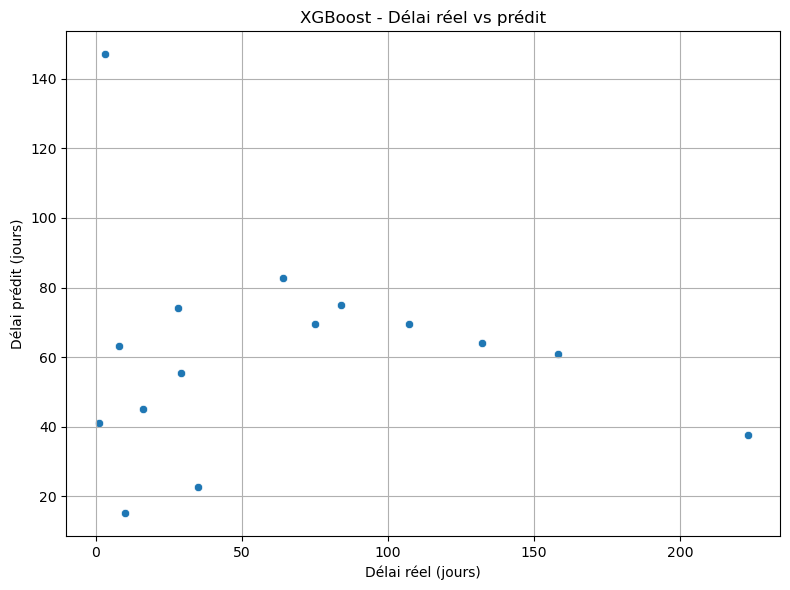

✅ Export terminé : 'prochaine_maintenance_predite_xgboost.csv' créé avec succès.


In [17]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ✅ Fonction accuracy custom
def accuracy_within_tolerance(y_true, y_pred, tolerance_days=10):
    correct = np.abs(y_true - y_pred) <= tolerance_days
    return np.mean(correct)

# 🔗 Connexion SQL
conn = pyodbc.connect(
    r'DRIVER={SQL Server};'
    r'SERVER=DESKTOP-STG70TI\SQLSERVER;'
    r'DATABASE=DW_SAP_Co2;'
    r'Trusted_Connection=yes;'
)

# 📥 Charger les données
query = """
WITH Historique AS (
    SELECT 
        f.FK_Equipment,
        f.Fk_Material,
        f.Fk_Location,
        f.Fk_Date_Creation_Notification,
        f.FK_Notif_Type,
        f.Fk_usine,
        f.Prioryty,
        d.FullDate AS Date_Creation,
        e.Fk_Mfrequency,
        e.Fk_MCycle,
        e.Fk_Category,
        e.Fk_Energy,
        e.Manufacturer,
        e.Estimated_Lifetime_Years
    FROM Fact_MM_PM f
    JOIN Dim_Date d ON f.Fk_Date_Creation_Notification = d.Pk_Date
    JOIN Dim_Equipment e ON f.FK_Equipment = e.PK_Equipment
    WHERE f.Fk_Date_Creation_Notification IS NOT NULL
)
SELECT * FROM Historique
"""

df = pd.read_sql(query, conn)
conn.close()

# 🧹 Nettoyage
df = df.drop_duplicates(subset=['FK_Equipment', 'Fk_Date_Creation_Notification'])
df['Date_Creation'] = pd.to_datetime(df['Date_Creation'])
df = df.sort_values(by=['FK_Equipment', 'Date_Creation'])

# ⏱️ Calcul du délai entre pannes
df['Delai_Entre_Pannes'] = df.groupby('FK_Equipment')['Date_Creation'].diff().dt.days
df = df.dropna(subset=['Delai_Entre_Pannes'])

# ➕ Features supplémentaires
df['Nombre_de_pannes_passées'] = df.groupby('FK_Equipment').cumcount()
df['Mois_panne'] = df['Date_Creation'].dt.month

# 🧾 Séparation des variables
X = df.drop(columns=['Date_Creation', 'Delai_Entre_Pannes'])
y = df['Delai_Entre_Pannes']

categorical_cols = [col for col in X.columns if 'Fk_' in col or col in ['Prioryty', 'Manufacturer']]

# 🏗️ Pipeline avec XGBoost
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=300, learning_rate=0.05, max_depth=5))
])

# 🔀 Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🚀 Entraînement
pipeline.fit(X_train, y_train)

# 🔮 Prédictions
y_pred = pipeline.predict(X_test)

# 📊 Évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
accuracy_tolerance = accuracy_within_tolerance(y_test, y_pred, tolerance_days=60)

print("📈 Évaluation du modèle XGBoost (régression sur délai en jours) :")
print(f"MAE = {mae:.2f} jours")
print(f"RMSE = {rmse:.2f} jours")
print(f"R² = {r2:.3f}")
print(f"Accuracy (erreur <= 10 jours) = {accuracy_tolerance*100:.2f}%")

# 📈 Graphique délai réel vs prédit
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Délai réel (jours)')
plt.ylabel('Délai prédit (jours)')
plt.title('XGBoost - Délai réel vs prédit')
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔥 Prédire la prochaine maintenance
df_last = df.groupby('FK_Equipment').tail(1).copy()

X_pred = df_last.drop(columns=['Date_Creation', 'Delai_Entre_Pannes'])
delais_predits = pipeline.predict(X_pred)

delais_predits = np.ceil(delais_predits)

df_last['Delai_prédit_jours'] = delais_predits
df_last['Prochaine_date_estimée'] = df_last['Date_Creation'] + pd.to_timedelta(df_last['Delai_prédit_jours'], unit='d')

df_last_export = df_last[['FK_Equipment', 'Date_Creation', 'Delai_prédit_jours', 'Prochaine_date_estimée']]
df_last_export.to_csv('prochaine_maintenance_predite_xgboost.csv', index=False, encoding='utf-8-sig')

print("✅ Export terminé : 'prochaine_maintenance_predite_xgboost.csv' créé avec succès.")


In [19]:
from sklearn.ensemble import GradientBoostingRegressor

# 🏗️ Pipeline avec Gradient Boosting
pipeline_gb = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42))
])

# 🔀 Split (c'est le même que plus haut)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🚀 Entraînement
pipeline_gb.fit(X_train, y_train)

# 🔮 Prédictions
y_pred_gb = pipeline_gb.predict(X_test)

# 📊 Évaluation
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)
accuracy_gb = accuracy_within_tolerance(y_test, y_pred_gb, tolerance_days=90)

print("📈 Évaluation Gradient Boosting :")
print(f"MAE = {mae_gb:.2f} jours")
print(f"RMSE = {rmse_gb:.2f} jours")
print(f"R² = {r2_gb:.3f}")
print(f"Accuracy (erreur <= 10 jours) = {accuracy_gb*100:.2f}%")


📈 Évaluation Gradient Boosting :
MAE = 55.02 jours
RMSE = 75.14 jours
R² = -0.400
Accuracy (erreur <= 10 jours) = 80.00%


In [21]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# 🏗️ Pipeline corrigé
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

pipeline_hist = Pipeline([
    ('preprocessing', preprocessor),
    ('model', HistGradientBoostingRegressor(max_iter=300, learning_rate=0.05, max_depth=5, random_state=42))
])

pipeline_hist.fit(X_train, y_train)
y_pred_hist = pipeline_hist.predict(X_test)

# 📊 Évaluation
print("📈 HistGradientBoosting :")
print(f"MAE = {mean_absolute_error(y_test, y_pred_hist):.2f}")
print(f"RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_hist)):.2f}")
print(f"R² = {r2_score(y_test, y_pred_hist):.3f}")


📈 HistGradientBoosting :
MAE = 61.62
RMSE = 73.78
R² = -0.349
